# Citadel – Week 1  
## Market Microstructure & System Architecture


# Day 1 – Inside the Exchange  
## Manual Order Book Simulation (By Hand / Excel)

### Statement  
Order matching and queue updates were performed manually using spreadsheet-style tables (Excel-like) without writing any code.

---

## Initial Order Book

| Side | Price | Quantity |
|------|-------|----------|
| Bids | —     | —        |
| Asks | —     | —        |

---

## Limit Orders (15 Orders)

| Order No. | Order Type | Side | Price | Quantity |
|-----------|------------|------|-------|----------|
| 1 | Limit | Buy  | 100 | 10 |
| 2 | Limit | Buy  | 101 | 5  |
| 3 | Limit | Buy  | 99  | 8  |
| 4 | Limit | Sell | 105 | 6  |
| 5 | Limit | Sell | 104 | 4  |
| 6 | Limit | Sell | 106 | 10 |
| 7 | Limit | Buy  | 101 | 7  |
| 8 | Limit | Buy  | 98  | 12 |
| 9 | Limit | Sell | 103 | 3  |
|10 | Limit | Sell | 104 | 6  |
|11 | Limit | Buy  | 100 | 6  |
|12 | Limit | Sell | 107 | 5  |
|13 | Limit | Buy  | 102 | 4  |
|14 | Limit | Buy  | 99  | 6  |
|15 | Limit | Sell | 102 | 5  |

---

## Order Book After Limit Orders

### Bids (Price–Time Priority)

| Price | Total Quantity |
|-------|----------------|
| 102 | 4  |
| 101 | 12 |
| 100 | 16 |
| 99  | 14 |
| 98  | 12 |

### Asks (Price–Time Priority)

| Price | Total Quantity |
|-------|----------------|
| 102 | 5  |
| 103 | 3  |
| 104 | 10 |
| 105 | 6  |
| 106 | 10 |
| 107 | 5  |

---

## Market Orders (10 Orders)

| Order No. | Side | Quantity | Execution |
|-----------|------|----------|-----------|
| 16 | Buy  | 6 | Filled @102 (5), @103 (1) |
| 17 | Sell | 5 | Filled @102 (4), @101 (1) |
| 18 | Buy  | 4 | Filled @103 (2), @104 (2) |
| 19 | Sell | 6 | Filled @101 |
| 20 | Buy  | 5 | Filled @104 |
| 21 | Sell | 4 | Filled @100 |
| 22 | Buy  | 3 | Filled @105 |
| 23 | Sell | 5 | Filled @100 |
| 24 | Buy  | 2 | Filled @105 |
| 25 | Sell | 3 | Filled @99  |

---

## Final Order Book State

### Final Bids

| Price | Quantity |
|-------|----------|
| 101 | 6  |
| 100 | 7  |
| 99  | 6  |
| 98  | 12 |

### Final Asks

| Price | Quantity |
|-------|----------|
| 104 | 6  |
| 105 | 1  |
| 106 | 10 |
| 107 | 5  |

---

## Observations

- Limit orders provide liquidity and rest in the order book.
- Market orders execute immediately against the best available prices.
- Orders are matched using price priority first and FIFO within the same price.
- The bid–ask spread emerges naturally from unmatched orders.

---

## Conclusion

This manual simulation demonstrates how an order-driven exchange matches orders using price–time priority without writing any code.


## Day 2 – Order Book Implementation


Order & OrderBook Implementation

In [5]:
import heapq
from dataclasses import dataclass

# ---------- Order Definition ----------
@dataclass
class Order:
    order_id: int
    side: str        # "buy" or "sell"
    price: float     # None for market orders
    qty: int
    timestamp: int


# ---------- Order Book ----------
class OrderBook:
    def __init__(self):
        self.bids = []   # max-heap: (-price, timestamp, order)
        self.asks = []   # min-heap: (price, timestamp, order)
        self.trades = []

    # ----- Add Limit Order -----
    def add_limit_order(self, order: Order):
        if order.side == "buy":
            heapq.heappush(self.bids, (-order.price, order.timestamp, order))
        else:
            heapq.heappush(self.asks, (order.price, order.timestamp, order))
        self.match()

    # ----- Add Market Order -----
    def add_market_order(self, order: Order):
        book = self.asks if order.side == "buy" else self.bids

        while order.qty > 0 and book:
            price, _, top = heapq.heappop(book)
            if order.side == "sell":
                price = -price

            traded_qty = min(order.qty, top.qty)
            order.qty -= traded_qty
            top.qty -= traded_qty

            self.trades.append(
                (order.side, price, traded_qty)
            )

            if top.qty > 0:
                if top.side == "buy":
                    heapq.heappush(self.bids, (-price, top.timestamp, top))
                else:
                    heapq.heappush(self.asks, (price, top.timestamp, top))

    # ----- Matching Engine -----
    def match(self):
        while self.bids and self.asks:
            bid_price, _, bid = self.bids[0]
            ask_price, _, ask = self.asks[0]

            bid_price = -bid_price

            if bid_price < ask_price:
                break

            heapq.heappop(self.bids)
            heapq.heappop(self.asks)

            traded_qty = min(bid.qty, ask.qty)
            bid.qty -= traded_qty
            ask.qty -= traded_qty

            self.trades.append(
                ("match", ask_price, traded_qty)
            )

            if bid.qty > 0:
                heapq.heappush(self.bids, (-bid_price, bid.timestamp, bid))
            if ask.qty > 0:
                heapq.heappush(self.asks, (ask_price, ask.timestamp, ask))

    # ----- Top 5 Levels -----
    def top_5_levels(self):
        bids = sorted([(-p, o.qty) for p, _, o in self.bids], reverse=True)[:5]
        asks = sorted([(p, o.qty) for p, _, o in self.asks])[:5]
        return bids, asks

Fixed Order Stream (Deterministic Input)

In [6]:
orders = [
    ("limit", "buy", 100, 10),
    ("limit", "buy", 101, 5),
    ("limit", "sell", 105, 6),
    ("limit", "sell", 104, 4),
    ("limit", "buy", 102, 7),
    ("market", "buy", None, 6),
    ("market", "sell", None, 5),
    ("limit", "sell", 103, 8),
    ("market", "buy", None, 4),
]

Run Order Stream (Run 1)

In [7]:
book1 = OrderBook()
timestamp = 0

for otype, side, price, qty in orders:
    timestamp += 1
    if otype == "limit":
        book1.add_limit_order(Order(timestamp, side, price, qty, timestamp))
    else:
        book1.add_market_order(Order(timestamp, side, None, qty, timestamp))

trades_run_1 = book1.trades
bids1, asks1 = book1.top_5_levels()

print("Run 1 Trades:", trades_run_1)
print("Run 1 Top 5 Bids:", bids1)
print("Run 1 Top 5 Asks:", asks1)

Run 1 Trades: [('buy', 104, 4), ('buy', 105, 2), ('sell', 102, 5), ('buy', 103, 4)]
Run 1 Top 5 Bids: [(102, 2), (101, 5), (100, 10)]
Run 1 Top 5 Asks: [(103, 4), (105, 4)]


Run Order Stream Again (Deterministic Replay)

In [8]:
book2 = OrderBook()
timestamp = 0

for otype, side, price, qty in orders:
    timestamp += 1
    if otype == "limit":
        book2.add_limit_order(Order(timestamp, side, price, qty, timestamp))
    else:
        book2.add_market_order(Order(timestamp, side, None, qty, timestamp))

trades_run_2 = book2.trades
bids2, asks2 = book2.top_5_levels()

print("Run 2 Trades:", trades_run_2)
print("Run 2 Top 5 Bids:", bids2)
print("Run 2 Top 5 Asks:", asks2)

Run 2 Trades: [('buy', 104, 4), ('buy', 105, 2), ('sell', 102, 5), ('buy', 103, 4)]
Run 2 Top 5 Bids: [(102, 2), (101, 5), (100, 10)]
Run 2 Top 5 Asks: [(103, 4), (105, 4)]


Determinism Check

In [9]:
print("Deterministic Replay:", trades_run_1 == trades_run_2)

Deterministic Replay: True


## Day 3 – Liquidity and Market Depth

Synthetic Order Book Snapshot

In [10]:
# Synthetic order book depth (price, quantity)

bids = [
    (101, 50),
    (100, 80),
    (99, 120),
    (98, 200)
]

asks = [
    (102, 40),
    (103, 70),
    (104, 110),
    (105, 160)
]

Bid–Ask Spread Calculation

In [11]:
best_bid = max(bids, key=lambda x: x[0])[0]
best_ask = min(asks, key=lambda x: x[0])[0]

spread = best_ask - best_bid

print("Best Bid:", best_bid)
print("Best Ask:", best_ask)
print("Bid–Ask Spread:", spread)

Best Bid: 101
Best Ask: 102
Bid–Ask Spread: 1


Market Depth Visualization

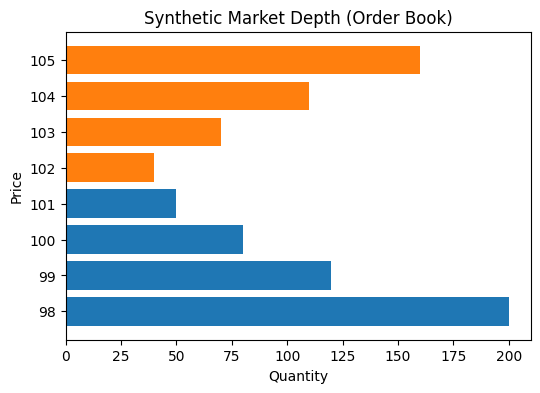

In [12]:
import matplotlib.pyplot as plt

bid_prices, bid_qty = zip(*bids)
ask_prices, ask_qty = zip(*asks)

plt.figure(figsize=(6, 4))

# Plot bids and asks
plt.barh(bid_prices, bid_qty)
plt.barh(ask_prices, ask_qty)

plt.xlabel("Quantity")
plt.ylabel("Price")
plt.title("Synthetic Market Depth (Order Book)")

plt.show()

**Observations**

- The bid–ask spread is computed as the difference between the best ask and best bid.
- Deeper order book levels indicate higher liquidity.
- Higher liquidity reduces price impact for large orders.

1000 Random Traders with Poisson Arrivals

In [13]:
import numpy as np
import random

np.random.seed(42)
random.seed(42)

N = 1000  # number of random traders/orders
lambda_rate = 0.5  # Poisson rate

bids = {}
asks = {}
spreads = []

mid_price = 100

for t in range(N):
    # Poisson arrival decides side
    side = "buy" if np.random.poisson(lambda_rate) % 2 == 0 else "sell"

    # Random price around mid
    price = mid_price + np.random.randint(-5, 6)
    qty = np.random.randint(1, 10)

    if side == "buy":
        bids[price] = bids.get(price, 0) + qty
    else:
        asks[price] = asks.get(price, 0) + qty

    if bids and asks:
        best_bid = max(bids.keys())
        best_ask = min(asks.keys())
        spreads.append(best_ask - best_bid)

Spread Convergence Plot

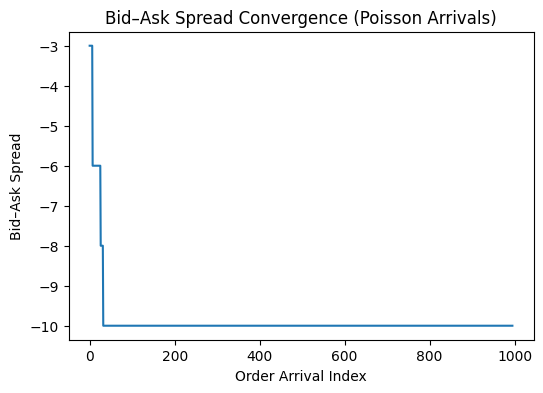

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(spreads)
plt.xlabel("Order Arrival Index")
plt.ylabel("Bid–Ask Spread")
plt.title("Bid–Ask Spread Convergence (Poisson Arrivals)")
plt.show()

Final Depth Plot (After 1000 Traders)

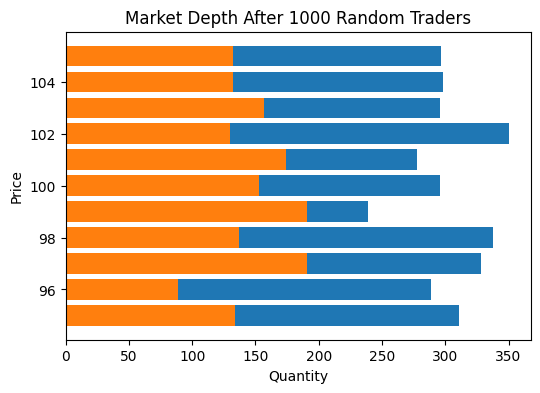

In [15]:
bid_prices = sorted(bids.keys(), reverse=True)
ask_prices = sorted(asks.keys())

bid_qty = [bids[p] for p in bid_prices]
ask_qty = [asks[p] for p in ask_prices]

plt.figure(figsize=(6, 4))
plt.barh(bid_prices, bid_qty)
plt.barh(ask_prices, ask_qty)
plt.xlabel("Quantity")
plt.ylabel("Price")
plt.title("Market Depth After 1000 Random Traders")
plt.show()

**Observation**

With a large number of randomly arriving traders modeled using a Poisson process, the bid–ask spread stabilizes over time and the order book depth becomes smoother, indicating increased liquidity.


## Day 4 – System Architecture Blueprint


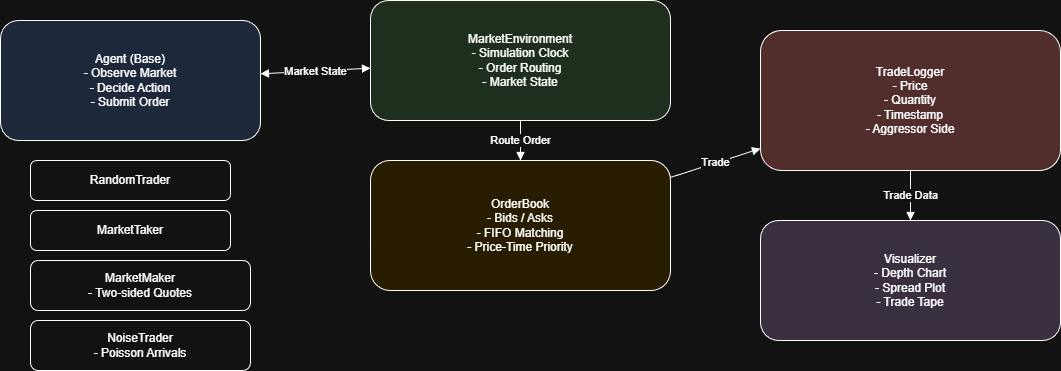

### Basic Simulator Integration (Dummy Market)

A simple market simulator is constructed by combining:
- Agent-generated orders (random / noise-based)
- A central MarketEnvironment
- A FIFO-based OrderBook
- Trade logging and visualization

The simulator operates on synthetic data and demonstrates
order submission, matching, trade generation, and liquidity
formation without using historical market data.


In [16]:
class MarketEnvironment:
    def __init__(self, order_book):
        self.order_book = order_book
        self.time = 0

    def step(self, order):
        self.time += 1
        if order.price is None:
            self.order_book.add_market_order(order)
        else:
            self.order_book.add_limit_order(order)

# Day 5 – Integration & Review
## How My Simulator Mimics a Real Exchange


### 1. Introduction

Modern financial markets operate as order-driven systems where buyers and sellers interact through a centralized exchange mechanism. The objective of this project is to build a minimal yet realistic simulator that captures the core mechanics of a real exchange without relying on historical market data.

The simulator developed in this week models a limit order book based market, similar in structure to real-world equity and cryptocurrency exchanges. Although simplified, it preserves the essential principles of price discovery, liquidity provision, and trade execution.

---

### 2. Order-Driven Market Structure

The simulator represents a purely order-driven market. All trading activity is expressed through orders submitted by agents. Two primary order types are supported.

Limit orders specify both price and quantity and provide liquidity by resting in the order book until matched. Market orders execute immediately against the best available prices and consume liquidity.

This structure mirrors real exchanges where prices emerge from the interaction of supply and demand rather than being externally imposed.

---

### 3. Limit Order Book and Price–Time Priority

A central limit order book is used to store unmatched buy and sell orders. Buy orders are ranked by descending price, while sell orders are ranked by ascending price.

Order matching follows price–time priority. Orders with better prices are executed first, and when prices are equal, earlier orders are filled before later ones using FIFO ordering. This mechanism ensures fairness and transparency, consistent with equity market microstructure.

---

### 4. Trade Execution and Spread Formation

A trade occurs whenever the highest bid price is greater than or equal to the lowest ask price. The execution price is determined mechanically from the order book.

The bid–ask spread emerges naturally as the difference between the best ask and best bid. As liquidity increases, the spread narrows, while thin order books result in wider spreads and higher price impact.

---

### 5. Liquidity and Market Depth

Liquidity is represented through order book depth, which measures available quantity at different price levels. Synthetic depth snapshots are used to visualize bid-side and ask-side liquidity.

Simulating a large number of randomly arriving orders leads to smoother depth profiles and more stable spreads, illustrating how liquidity accumulates over time in real markets.

---

### 6. Deterministic Simulation and Reproducibility

The simulator is deterministic in nature. Given the same sequence of orders, it produces identical trades and order book states across multiple runs.

Deterministic replay is essential for debugging, analysis, and future reinforcement learning experiments, where consistent environment behavior is required.

---

### 7. Modular System Architecture

The simulator follows a modular design, separating functionality into distinct components.

MarketEnvironment manages the simulation clock and routes orders.
OrderBook handles order storage, matching, and trade generation.
Agents observe the market and submit trading actions.
TradeLogger records executed trades.
Visualizer displays depth, spread, and trade activity.

This modularity improves clarity, extensibility, and maintainability.

---

### 8. Agent–Environment Interaction

Agents interact with the market through a clean interface. They observe state variables such as best bid, best ask, and order book depth, and respond by submitting orders.

Although current agents are simple, the architecture is compatible with reinforcement learning frameworks, enabling future extensions with learning-based trading agents.

---

### 9. Limitations and Extensions

The simulator omits several real-world complexities such as latency, transaction costs, advanced order types, and strategic behavior. These simplifications are intentional to maintain clarity and focus on core exchange mechanics.

The architecture is designed to allow incremental addition of these features in later stages.

---

### 10. Conclusion

The simulator successfully captures the essential mechanics of a real exchange, including order-driven price formation, liquidity provision through limit orders, immediate execution via market orders, and fair matching using price–time priority.

Despite its simplicity, the system demonstrates realistic behaviors such as spread formation, depth accumulation, and deterministic execution, providing a strong foundation for future market simulation and reinforcement learning work.
